In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

### Load News Articles Data

In [2]:
jan_df = pd.read_csv('./data/FT_all_between_1and2.csv', usecols=["date", "title"])
feb_df = pd.read_csv('./data/FT_all_between_2and3.csv', usecols=["date", "title"])
mar_df = pd.read_csv('./data/FT_all_between_3and4.csv', usecols=["date", "title"])
apr_df = pd.read_csv('./data/FT_all_between_4and5.csv', usecols=["date", "title"])
may_df = pd.read_csv('./data/FT_all_between_5and6.csv', usecols=["date", "title"])

In [3]:
df_dict = {'Jan': jan_df, 'Feb': feb_df, 'Mar': mar_df, 'Apr': apr_df, 'May': may_df}

In [4]:
jan_df.head(5)

,title,date
0,Mavericks behind Carlos Ghosn’s escape,2020-01-11
1,The Green Beret ex-con who allegedly helped Ca...,2020-01-07
2,How dangerous is the coronavirus and how does ...,2020-01-29
3,Can I justify flying business class to avoid j...,2020-01-29
4,Letter: Musk has overhyped Tesla’s autopilot f...,2020-01-30


### Data Pre-Processing

In [5]:
for key, df in df_dict.items():
    # remove nan
    df = df.dropna()

    # remove rows that are semantically invalid (this is specific to Financial Times articles)
    df = df[~df.title.str.contains("FT|Letter|Monday, |Tuesday, |Wednesday, |Thursday, |Friday, \
                                    |Cartoon, |Further reading")]
    df_dict[key] = df

In [6]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
numvec_dict = {'Jan': None, 'Feb': None, 'Mar': None, 'Apr': None, 'May': None}
for month in month_list:
    if month != 'Jan':
        headlines = pd.concat([headlines, df_dict[month]], ignore_index=True)
        numvec_dict[month] = df_dict[month].shape[0]
    else:
        headlines = df_dict['Jan'].copy()
        numvec_dict[month] = headlines.shape[0]
headlines.index = headlines['date']
print("numvec_dict: ", numvec_dict)

numvec_dict:  {'Jan': 3118, 'Feb': 2926, 'Mar': 3359, 'Apr': 3060, 'May': 2938}


In [7]:
def normalize_texts(texts):
    NON_ALPHANUM = re.compile(r'[\W]')
    NON_ASCII = re.compile(r'[^a-z0-1\s]')
    normalized_texts = ''
    lower = texts.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', lower)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii

In [8]:
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [9]:
# normalize and split
headlines['title'] = headlines['title'].apply(normalize_texts)
headlines['title'] = headlines['title'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
# print(headlines.head())
# top_n_words = get_top_n_words(headlines['title'], 15)
# print(top_n_words)

In [10]:
X = headlines.loc[:, 'title'].values
count_vect = CountVectorizer(lowercase=True)
count_vect = count_vect.fit(X)
X_sparse = count_vect.transform(X)
vocab = count_vect.vocabulary_
vocab_inverse = {}
for word, int_embedding in vocab.items():
    vocab_inverse[int_embedding] = word
total_words = X_sparse.sum()
total_words_unique = len(count_vect.vocabulary_)
print('total_words: {}'.format(total_words))
print('total_words_unique: {}'.format(total_words_unique))

total_words: 112078
total_words_unique: 15242


In [11]:
X_train = pd.DataFrame(X)
# headlines_smaller = X_train.sample(frac=0.2, random_state=423)
X_train.columns = ['head_line']

### Word2Vec Embedding

In [12]:
def load_word2vec():
    # importing wordtovec embeddings
    from gensim.models import KeyedVectors
    pretrained_embeddings_path = "./GoogleNews-vectors-negative300.bin.gz"     # download at: https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
    word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)
    return word2vec

In [13]:
word2vec = load_word2vec()

In [14]:
class WordVecVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in texts.split() if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for texts in X
        ])

In [15]:
# representing each headline by the mean of word embeddings for the words used in the headlines.
wtv_vect = WordVecVectorizer(word2vec)
X_train_wtv = wtv_vect.transform(X_train.head_line)
print(X_train_wtv.shape)

(15401, 300)


### K-means Clustering

In [16]:
# K-Means clustering
num_cluster = 5

km = KMeans(n_clusters=num_cluster, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X_train_wtv)
cluster_df = pd.DataFrame({'headlines': X_train.head_line, 'topic_cluster': y_km})

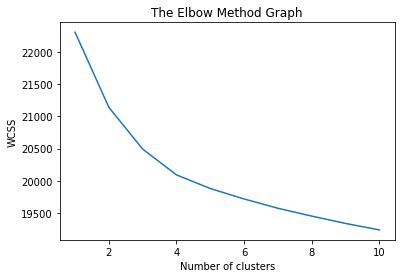

In [17]:
# use elbow method to find optimal K value
def elbow(X_train_wtv):
    wcss = []
    # this loop will fit the k-means algorithm to our data and
    # second we will compute the within cluster sum of squares and #appended to our wcss list.
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='random', max_iter=300, n_init=10, random_state=0)
        # i above is between 1-10 numbers. init parameter is the random #initialization method
        # we select kmeans++ method. max_iter parameter the maximum number of iterations there can be to
        # find the final clusters when the K-meands algorithm is running. we #enter the default value of 300
        # the next parameter is n_init which is the number of times the #K_means algorithm will be run with
        # different initial centroid.
        kmeans.fit(X_train_wtv)
        # kmeans algorithm fits to the X dataset
        wcss.append(kmeans.inertia_)

    # kmeans inertia_ attribute is:  Sum of squared distances of samples #to their closest cluster center.
    # 4.Plot the elbow graph
    plt.plot(range(1, 11), wcss)
    plt.title('The Elbow Method Graph')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

elbow(X_train_wtv)

The y-axis of this plot is Within-Cluster-Sum-of-Squares (WCSS): the smaller this value gets, the "tighter" each cluster is. The x-axis of this plot is the number of clusters: as this number increases, WCSS monotonically decreases.  
We do not want a unreasonably large number of clusters because we desire a meaningful categorization of news articles. The "elbow method" tells us to select the number where a significant decrease in WCSS is observed, and an additional cluster would not produce another significant decrease in WCSS. Here, num_cluster = 4 would be a good choice.  
However, when we analyzed the clustering results with human eyes, we found out that num_cluster = 5 did the best job in separating news in meaningfully different categories. So we went with num_cluster = 5 in this example. But one could still use this method as a good reference. 

### Visualization

In [50]:
def plot_clustering_separate(X_train_wtv, y_km, num_cluster, numvec_dict, month_list):
    from sklearn.decomposition import PCA
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
    pca = PCA(n_components=2)
    lda = LDA(n_components=2)  # 2-dimensional LDA

    lda_transformed = pd.DataFrame(lda.fit_transform(X_train_wtv, y_km))

    for month in month_list:
        if month == 'Jan':
            start = 0
            end = numvec_dict[month]
        else:
            start = end
            end += numvec_dict[month]
        lda_transformed_slice = lda_transformed.iloc[start:end]
        y_km_slice = y_km[start:end]

        fig, ax = plt.subplots()
        for i in range(num_cluster):
            ax.scatter(lda_transformed_slice[y_km_slice == i][0], lda_transformed_slice[y_km_slice == i][1], s=100, label='Cluster %s' % str(i+1))
            ax.legend()
        plt.title('2D Projection of the Clustering Results in %s' % month)
        plt.xlabel('dimension 1')
        plt.ylabel('dimension 2')
        plt.show()
        plt.close()

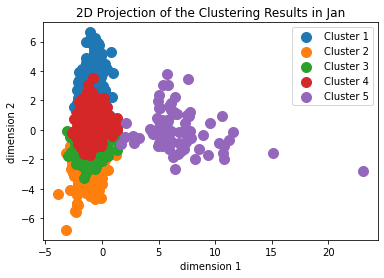

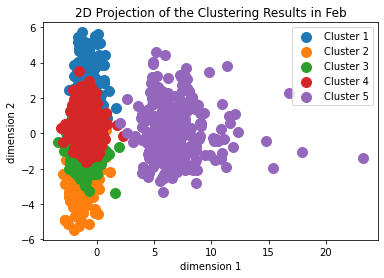

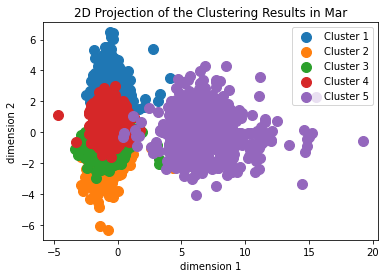

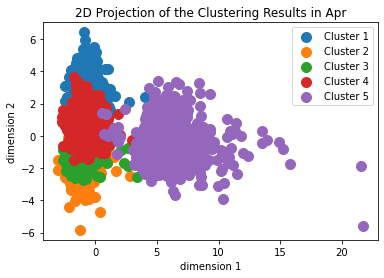

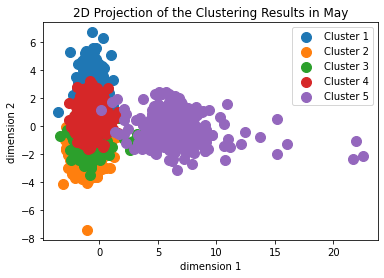

In [51]:
# plot clustering
plot_clustering_separate(X_train_wtv, y_km, num_cluster, numvec_dict, month_list)

In [55]:
# top words in each cluster
for c in range(num_cluster):
    words = []
    word_values = []
    for i, j in get_top_n_words(cluster_df[cluster_df['topic_cluster'] == c]['headlines'], 15):
        words.append(i)
        word_values.append(j)
    print("Top words in cluster %s are:" % str(c+1), words)
    print("")

Top words in cluster 1 are: ['investors', 'market', 'oil', 'debt', 'fund', 'banks', 'bank', 'markets', 'china', 'bond', 'stocks', 'hit', 'global', 'funds', 'sales']

Top words in cluster 2 are: ['johnson', 'new', 'boris', 'europe', 'china', 'trump', 'london', 'markets', 'india', 'hong', 'kong', 'lockdown', 'iran', 'britain', 'deal']

Top words in cluster 3 are: ['new', 'lockdown', 'world', 'covid', 'best', 'time', 'china', 'home', 'big', 'work', 'life', 'tech', 'business', 'brexit', 'way']

Top words in cluster 4 are: ['chief', 'new', 'trump', 'deal', 'virus', 'lockdown', 'business', 'government', 'says', 'warns', 'pandemic', 'talks', 'covid', 'brexit', 'trade']

Top words in cluster 5 are: ['coronavirus', 'china', 'happened', 'crisis', 'hit', 'warns', 'outbreak', 'new', 'lockdown', 'global', 'hits', 'fears', 'fight', 'death', 'trump']



Cluster 5 in these graphs is the news article cluster for COVID_19 related news. They look significantly distant from the other 4 clusters, especially when this cluster first emerged in January.  
Note that, for better visualization, we actually aggregate all news articles from Jan to May, and did a single clustering. This approach is problematic. But in this case, we verified in human eyes, that clustering separately for news articles produced in each month (this is the right way) would result in a similar cluster pattern. 

### Calculate Pointwise Cluster Distance

In [30]:
def cluster_distance(X_train_wtv, y_km, num_cluster, numvec_dict, month_list):
    cluster_heads = {'Jan': [], 'Feb': [], 'Mar': [], 'Apr': [], 'May': []}
    distance_table_dict = {'Jan': [], 'Feb': [], 'Mar': [], 'Apr': [], 'May': []}
    for month in month_list:
        if month == 'Jan':
            start = 0
            end = numvec_dict[month]
        else:
            start = end
            end += numvec_dict[month]
        X_train_wtv_slice = X_train_wtv[start:end]
        y_km_slice = y_km[start:end]

        # step 1: find cluster heads, defined as the mean of all vectors in the cluster
        for i in range(num_cluster):
            temp = X_train_wtv_slice[y_km_slice == i].mean(axis=0).reshape(1, 300)
            cluster_heads[month].append(temp)

        # step 2: calculate pointwise distance between cluster heads in the same month
        distance_table = []
        for i in range(num_cluster):
            row = []
            for j in range(num_cluster):
                euc_dist = np.linalg.norm(cluster_heads[month][i] - cluster_heads[month][j])    # euclidean distance
                row.append(euc_dist)
            distance_table.append(row)
        distance_table_dict[month] = distance_table
    return distance_table_dict

In [31]:
distance_table_dict = cluster_distance(X_train_wtv, y_km, num_cluster, numvec_dict, month_list)

In [53]:
for month in month_list:
    print(month + ' pointwise cluster distance')
    idx = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
    df = pd.DataFrame(distance_table_dict[month], index = idx)
    df.columns = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
    print(df)
    print('-------'*10 + '\n')

Jan pointwise cluster distance
           cluster 1  cluster 2  cluster 3  cluster 4  cluster 5
cluster 1   0.000000   0.647544   0.539668   0.433266   0.939029
cluster 2   0.647544   0.000000   0.515890   0.550858   1.005548
cluster 3   0.539668   0.515890   0.000000   0.389199   0.945815
cluster 4   0.433266   0.550858   0.389199   0.000000   0.958850
cluster 5   0.939029   1.005548   0.945815   0.958850   0.000000
----------------------------------------------------------------------

Feb pointwise cluster distance
           cluster 1  cluster 2  cluster 3  cluster 4  cluster 5
cluster 1   0.000000   0.669663   0.555735   0.439033   0.915673
cluster 2   0.669663   0.000000   0.502536   0.549964   0.971917
cluster 3   0.555735   0.502536   0.000000   0.402576   0.922646
cluster 4   0.439033   0.549964   0.402576   0.000000   0.933193
cluster 5   0.915673   0.971917   0.922646   0.933193   0.000000
----------------------------------------------------------------------

Mar pointwise 

As we can see, cluster 5 has the largest pointwise cluster distance with other clusters in average.  
On a separate note, that distance is reducing as time develops (from January to May).